## Global properties 1

In [21]:
using PyCall
using Distributions
using Statistics
using DataFrames

using Distances
using Random , Printf

rootdir = "/home/stephane/Science/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot , CSV

wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
ocdir   = "$rootdir/products/oc"

cd(wdir)

In [22]:
## compute global properties

function compute_globalparams(df, dfout, votname)
    ram= median(df[:ra])
    decm= median(df[:dec])
    lm= median(df[:l])
    bm= median(df[:b])
    pmram= median(df[:pmra])
    pmdecm= median(df[:pmdec])
    distm= median(df[:distance])
    Xm= median(df[:X]) 
    Ym= median(df[:Y])
    Zm= median(df[:Z])
    vbm= median(df[:vb])
    vlm= median(df[:vl])
    vrm= radialVelocity(df[:vrad])

    Xgalm, Ygalm , Zgalm= _galXYZ(lm , bm , distm) 
    uvw= _galUVW(ram, decm, distm, pmram, pmdecm, vrm)
    
    println(vrm)
    println(uvw)
    
    push!(dfout, (votname,ram, decm, lm, bm, distm, Xm, Ym, Zm, Xgalm, Ygalm, Zgalm, vlm, vbm, vrm,
            uvw[1],uvw[2],uvw[3]))
    return(0)
    
end

compute_globalparams (generic function with 1 method)

In [23]:
## median of radial velocity
function radialVelocity(vrad)
    v=[]
    for vel in vrad
        if !isnan(vel)
            push!(v,vel)
        end
    end
    
    if length(v)==0
        push!(v,-999)
    end
    return(mean(v))
end

## Compute the X,Y,Z galactic coordinates (centered on the Galactic Center)
## See Ellsworth-Bowers et al. (2013)
## Rgal was updated from Anderson et al. (2018)

function _galXYZ(l,b,distance)
    Rgal= 8.34e3
    zsun= 25
    θ= asin(zsun/Rgal)
    
    xg= Rgal*cos(θ)-distance*(cosd(l)cosd(b)cos(θ)+sind(b)sin(θ))
    yg= -distance*sind(l)cosd(b)
    zg= Rgal*sin(θ)-distance*(cosd(l)cosd(b)sin(θ)-sind(b)cos(θ))
    
    return(xg,yg,zg)
end


### compute galactic U V W from idlastro gal_uvw.pro
##
## ra, dec: degrees
## distance; pc
## pmra,pmdec: milliarcsec/yr
## vrad: km/s

## UVW: km/s
#      U - Velocity (km/s) positive toward the Galactic *anti*center
#      V - Velocity (km/s) positive in the direction of Galactic rotation
#      W - Velocity (km/s) positive toward the North Galactic Pole

function _galUVW(ra, dec, distance, pmra, pmdec, vrad ; LSR_vel=[-8.5 ; 13.38 ; 6.49])
    k = 4.74047     #Equivalent of 1 A.U/yr in km/s   
    
    T=  [0.0548756   0.873437  0.483835 ;
          0.494109   -0.44483   0.746982 ;
         -0.867666   -0.198076  0.455984]

    A1= [ cosd(ra) sind(ra) 0 ; sind(ra) -cosd(ra) 0 ; 0 0 -1]
    A2= [ cosd(dec) 0 -sind(dec) ; 0 -1 0 ; -sind(dec) 0 -cosd(dec)]
    vec1 = vrad
    vec2 = k*pmra*1e-3*distance
    vec3 = k*pmdec*1e-3*distance
    v= [vec1 ; vec2 ; vec3]
    
    uvw= T*A1*A2*v + LSR_vel
         
    return(uvw)
end

_galUVW (generic function with 1 method)

In [24]:
## Main loop
##

macro main(paramfile)
    let
        println("## Starting main loop..")
        spl= CSV.read(paramfile , delim= ";")
        println("## $paramfile read..") 
        s=size(spl)
        
        dfout= DataFrame(votname=String[], ram= Float64[], decm= Float64[], lm= Float64[], bm= Float64[], 
            distm= Float64[], Xm= Float64[], Ym= Float64[], Zm= Float64[], Xgalm= Float64[], 
            Ygalm= Float64[], Zgalm= Float64[], vlm= Float64[], vbm= Float64[], vrm= Float64[] ,
            U= Float64[],V= Float64[], W= Float64[])
        
        for i in 1:s[1]
            votname = spl[:votname][i]
            println("## Starting with $votname")
            
            ocfile= @sprintf("%s/%s-oc.csv",ocdir,votname[1:end-4])
            @printf("### oc file: %s \n",ocfile)
            
            df= CSV.read(ocfile,delim=";")
            compute_globalparams(df, dfout, votname)
        end
        
        fileout= @sprintf("%s-SCglobal.csv",paramfile[1:end-4])
        CSV.write(fileout, dfout, delim=";")
        println("## $fileout written...")
        return(fileout)
    end
end

@main (macro with 1 method)

In [25]:
fileres= @main("votlist.finalSample_metric0.01.csv")

## Starting main loop..
## votlist.finalSample_metric0.01.csv read..
## Starting with Alessi 1-2.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 1-2.1deg-oc.csv 
-5.938454829715795
[1.30383, -1.58207, 1.02845]
## Starting with Alessi 12-2.4deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 12-2.4deg-oc.csv 
5.2948048263622205
[-11.9406, 14.0829, -10.4548]
## Starting with Alessi 13-15.9deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 13-15.9deg-oc.csv 
16.87630451253537
[3.60512, -7.87471, 2.63519]
## Starting with Alessi 20-1.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 20-1.5deg-oc.csv 
-5.109556569613011
[2.84851, 1.13804, -0.763476]
## Starting with Alessi 21-1.6deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 21-1.6deg-oc.csv 
41.889825545390394
[30.9753, -5.8491, -3.55656]
## Starting with Alessi 2-1.7deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 2-1.7deg-oc.c

5.362797112158161
[-17.5544, 2.17302, 3.92735]
## Starting with ASCC 97-1.7deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/ASCC 97-1.7deg-oc.csv 
14.416360936720817
[-26.7861, -2.26887, 1.27482]
## Starting with ASCC 99-1.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/ASCC 99-1.2deg-oc.csv 
-45.343576523478916
[38.081, -0.5317, -13.486]
## Starting with B 35-2.8deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/B 35-2.8deg-oc.csv 
24.903368253496527
[13.5785, 1.63315, 1.70322]
## Starting with Barkhatova 2-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Barkhatova 2-1.0deg-oc.csv 
-9.973296158066338
[-5.91647, 2.87964, -2.03749]
## Starting with Basel 17-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Basel 17-1.0deg-oc.csv 
5.494846923264924
[14.707, -0.705171, 8.12404]
## Starting with Basel 20-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Basel 20-1.0deg-oc.csv 
-2.4620186457403515
[53.4323, 7.99

-6.24254831444432
[-1.97601, 8.35305, 2.33412]
## Starting with FSR 0295-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 0295-1.0deg-oc.csv 
-16.07055630329426
[3.38963, -3.23969, 0.751878]
## Starting with FSR 0304-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 0304-1.0deg-oc.csv 
-17.623881214320264
[3.42686, -4.81324, 0.782038]
## Starting with FSR 0319-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 0319-1.0deg-oc.csv 
-10.239484319213286
[-5.6888, 2.53453, -2.3075]
## Starting with FSR 0351-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 0351-1.0deg-oc.csv 
-46.90745072300471
[-36.3163, -28.6148, 5.40219]
## Starting with FSR 0354-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 0354-1.0deg-oc.csv 
-15.782789256220529
[-1.61587, -4.3568, 7.44042]
## Starting with FSR 0388-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 0388-1.1deg-oc.csv 
-37.73258840606459
[-33.

25.020223879761676
[11.0263, -10.1323, -0.128241]
## Starting with IC 2488-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/IC 2488-1.1deg-oc.csv 
-2.4620186457403515
[53.2702, 8.04145, -1.63499]
## Starting with IC 2602-6.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/IC 2602-6.0deg-oc.csv 
16.191686930765897
[0.107863, -6.90005, 5.78794]
## Starting with IC 2714-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/IC 2714-1.0deg-oc.csv 
-13.426404530856761
[45.2495, 5.78492, 5.40842]
## Starting with IC 446-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/IC 446-1.0deg-oc.csv 
16.515945823265447
[2.72492, -3.07297, -7.52364]
## Starting with IC 4651-1.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/IC 4651-1.2deg-oc.csv 
-29.62177954595609
[27.8982, 0.387231, 7.22486]
## Starting with IC 4665-3.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/IC 4665-3.5deg-oc.csv 
-12.267001811679904
[-6.31013, -3.248

24.563975928874058
[12.3263, 1.34849, 0.82464]
## Starting with NGC 2099-2.4deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 2099-2.4deg-oc.csv 
6.166278658628622
[-0.23262, -26.9132, -1.49203]
## Starting with NGC 2112-3.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 2112-3.1deg-oc.csv 
31.840926918482694
[30.7967, 24.2056, -2.46186]
## Starting with NGC 2126-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 2126-1.1deg-oc.csv 
-10.273099402554143
[-12.7272, -5.43393, 1.87263]
## Starting with NGC 2129-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 2129-1.0deg-oc.csv 
-999.0
[-1002.62, 113.828, 3.50881]
## Starting with NGC 2168-4.9deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 2168-4.9deg-oc.csv 
-5.390619948242528
[-15.707, -1.14529, 8.82031]
## Starting with NGC 2175-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 2175-1.0deg-oc.csv 
-15.359106582787357
[-25.0344, 8.16728

-999.0
[792.998, 609.251, -39.2404]
## Starting with NGC 5925-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 5925-1.0deg-oc.csv 
-20.829201463308863
[34.039, -10.894, -6.73185]
## Starting with NGC 6025-1.7deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 6025-1.7deg-oc.csv 
5.284119384169413
[-3.69823, -2.2088, 4.79083]
## Starting with NGC 6031-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 6031-1.0deg-oc.csv 
-19.733588820006087
[13.787, 14.4274, 7.24384]
## Starting with NGC 6124-2.3deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 6124-2.3deg-oc.csv 
1.67301042781705
[-4.04299, -6.5027, 2.7468]
## Starting with NGC 6134-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 6134-1.1deg-oc.csv 
-23.190274001338786
[16.5991, 14.6832, -19.4956]
## Starting with NGC 6167-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 6167-1.1deg-oc.csv 
-0.6090920038676018
[0.0696083, -3.1675, -3.

-53.96390368529627
[-38.3188, -33.5319, -1.11064]
## Starting with Platais 3-11.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Platais 3-11.2deg-oc.csv 
8.09002066535744
[9.42585, 8.15498, 0.31446]
## Starting with Platais 4-3.3deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Platais 4-3.3deg-oc.csv 
-5.743680320695216
[-15.4876, 8.57688, 0.0753594]
## Starting with Platais 5-10.3deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Platais 5-10.3deg-oc.csv 
25.17387482466457
[6.88827, -2.35687, -13.519]
## Starting with Platais 6-6.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Platais 6-6.5deg-oc.csv 
31.76339420138988
[30.7458, 24.2751, -2.44423]
## Starting with Platais 8-6.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Platais 8-6.0deg-oc.csv 
20.997132971864115
[2.35233, -8.79461, 2.36003]
## Starting with Platais 9-5.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Platais 9-5.5deg-oc.csv 
21.3275333069

"votlist.finalSample_metric0.01-SCglobal.csv"

In [26]:
## plots of the sample properties
df= CSV.read(fileres, delim=";")

,votname,ram,decm,lm,bm,distm,Xm,Ym,Zm,Xgalm,Ygalm,Zgalm,vlm,vbm,vrm,U,V,W
,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,Alessi 1-2.1deg.vot,12.389,50.1866,122.626,-12.6708,466.936,466.9,-5.10677,4.85472,8585.89,-383.68,-76.6856,16.375,-6.87887,-5.93845,1.30383,-1.58207,1.02845
2,Alessi 12-2.4deg.vot,310.866,23.7858,67.4408,-11.4671,544.766,544.638,0.53147,-1.01656,8135.47,-493.04,-83.916,-2.89748,-16.2117,5.2948,-11.9406,14.0829,-10.4548
3,Alessi 13-15.9deg.vot,51.7494,-35.9102,237.665,-55.9141,104.32,104.246,-1.75495,-3.81938,8371.49,49.399,-61.3037,1.09946,18.0723,16.8763,3.60512,-7.87471,2.63519
4,Alessi 20-1.5deg.vot,2.54594,58.6922,117.591,-3.74567,432.505,432.44,-0.570861,-0.365765,8539.94,-382.5,-2.65528,15.6493,-7.67239,-5.10956,2.84851,1.13804,-0.763476
5,Alessi 21-1.6deg.vot,107.648,-9.3955,223.441,-0.0506966,570.626,570.597,0.631322,-1.026,8754.28,392.366,25.7371,-13.1522,-10.0216,41.8898,30.9753,-5.8491,-3.55656
6,Alessi 2-1.7deg.vot,71.5686,55.1563,152.353,6.3323,627.918,627.873,0.848609,-0.340607,8892.58,-289.594,95.9129,0.701823,-4.09883,-10.6923,-17.2031,8.05151,1.29352
7,Alessi 3-2.2deg.vot,109.139,-46.3095,257.626,-15.2509,281.242,281.225,-0.990263,0.443466,8398.33,265.035,-48.8051,-19.7745,-5.70257,2.14782,10.9226,17.0759,0.407929
8,Alessi 5-1.8deg.vot,160.904,-61.1041,288.103,-1.9807,399.135,399.106,-0.123598,0.229736,8216.06,379.151,10.8333,-27.913,-9.44217,9.96882,15.0386,-4.45714,-3.27957
9,Alessi 62-1.4deg.vot,283.993,21.6084,52.8114,8.69209,627.901,627.896,-0.139446,-0.46249,7964.51,-494.472,118.766,-2.55261,-2.34809,10.6799,-17.1374,20.518,5.82162


In [27]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(df.Xgalm,df.Ygalm,"ob", markersize = 1)
#ax.set_xlim([1.0,4.])
#ax.set_ylim([1.0,4.])
PyPlot.xlabel("X (Gal)")
PyPlot.ylabel("Y (Gal)")

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(df.Zgalm,df.Ygalm,"ob", markersize = 1)
#ax.set_xlim([1.0,4.])
#ax.set_ylim([1.0,4.])
PyPlot.xlabel("Z (Gal)")
PyPlot.ylabel("Y (Gal)")

ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(df.Xgalm,df.Zgalm,"ob", markersize = 1)
q = ax.quiver(X, Y, U, V)
#ax.set_xlim([1.0,4.])
#ax.set_ylim([1.0,4.])
PyPlot.xlabel("X (Gal)")
PyPlot.ylabel("Z (Gal)")

PyPlot.show()


UndefVarError: UndefVarError: X not defined

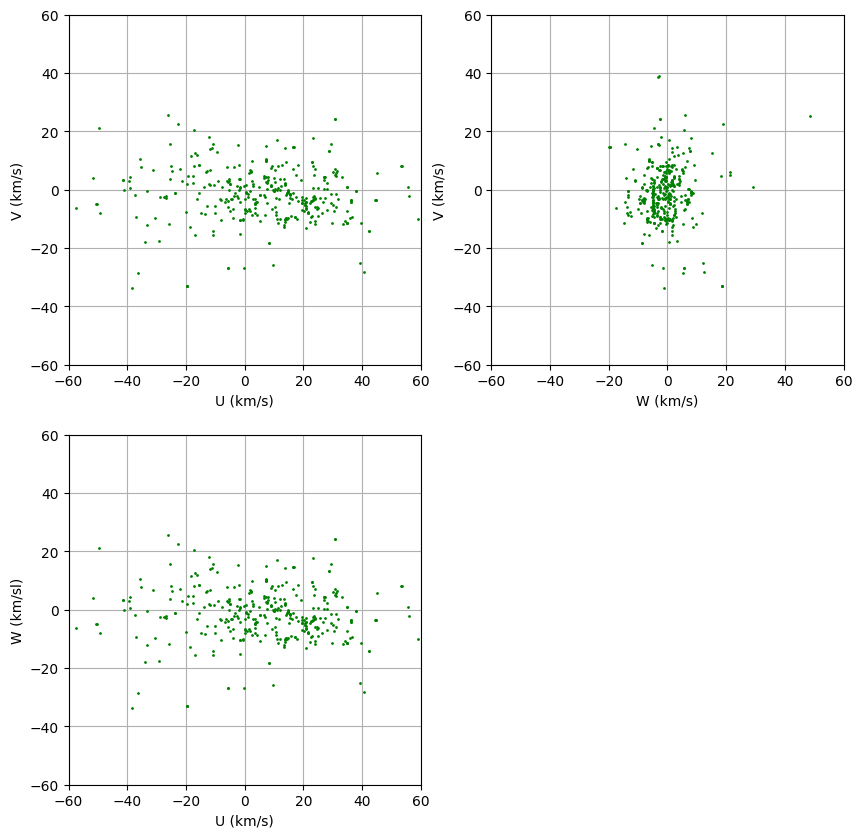

In [28]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(df.U,df.V,"og", markersize = 1)
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
PyPlot.xlabel("U (km/s)")
PyPlot.ylabel("V (km/s)")

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(df.W,df.V,"og", markersize = 1)
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
PyPlot.xlabel("W (km/s)")
PyPlot.ylabel("V (km/s)")

ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(df.U,df.V,"og", markersize = 1)
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
PyPlot.xlabel("U (km/s)")
PyPlot.ylabel("W (km/sl)")

PyPlot.show()


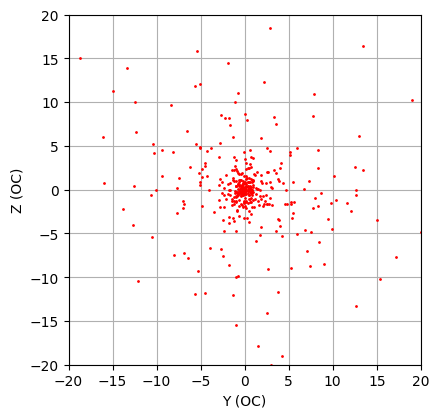

In [29]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(df.Ym,df.Zm,"or", markersize = 1)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
PyPlot.xlabel("Y (OC)")
PyPlot.ylabel("Z (OC)")

PyPlot.show()

In [30]:
## Testing the galUVW
ra = 17.4294147     
dec = 61.5473037
pmra = 628.42  
pmdec = 76.65         
dis = 139    
vrad = -321.4

galUVW(ra, dec, dis, pmra, pmdec, vrad)

3-element Array{Float64,1}:
  142.66334526956078
 -483.5514385092469 
   93.21583782047652